# Time Series Model Training Test
This notebook tests training and evaluation for ARIMA, SARIMA, Prophet, Naive, RandomForest, and XGBoost models on the same dataset. Fill in your dataset path in the placeholder below.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import mlflow
import io
import base64


In [2]:
# Set dataset path (replace with your actual path)

# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DATASET_PATH = '../AEP_hourly.csv'  # Adjust this path as needed

df = pd.read_csv(DATASET_PATH)
# Adjust columns for training
df = pd.read_csv(DATASET_PATH)
df = df.rename(columns={'Datetime': 'datetime', 'AEP_MW': 'consumption'})
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime').sort_index()

⚠️ **Warning: ARIMA and SARIMA models may perform poorly on your data.**

- These models require the data to be stationary (no trend/seasonality) and are sensitive to outliers and high-frequency data.
- If your data has strong or complex seasonality, is non-stationary, or contains outliers, ARIMA/SARIMA may give poor forecasts.
- For best results, these models often need careful, personalized preprocessing (differencing, transformations, outlier removal) and parameter tuning.
- Consider using Prophet, XGBoost, or RandomForest for more robust results on real-world data.

# Test LightGBM and CatBoost for Time Series Forecasting
We add LightGBM and CatBoost regressors, which are powerful gradient boosting models, to compare their performance with RandomForest and XGBoost. These models often perform well on structured/tabular time series data with proper feature engineering.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 97017, number of used features: 3
[LightGBM] [Info] Start training from score 15695.455693


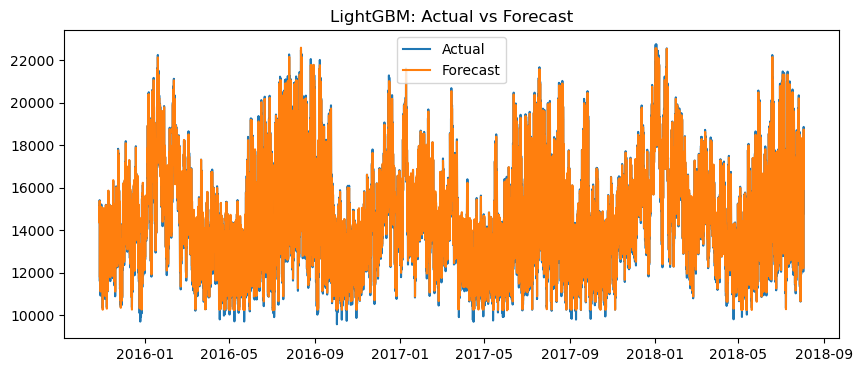

MAE: 414.227 | RMSE: 524.471


In [4]:
# Train and evaluate LightGBM model
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Feature engineering: lag-1, month, weekday (ensure consistent naming)
df_ml = df.copy()
df_ml['lag1'] = df_ml['consumption'].shift(1)
df_ml['month'] = df_ml.index.month
df_ml['weekday'] = df_ml.index.weekday

df_ml = df_ml.dropna()

X_ml = df_ml[['lag1', 'month', 'weekday']]
y_ml = df_ml['consumption']

# Train/test split (last 20% for test)
split_idx = int(len(df_ml) * 0.8)
X_train_ml, X_test_ml = X_ml.iloc[:split_idx], X_ml.iloc[split_idx:]
y_train_ml, y_test_ml = y_ml.iloc[:split_idx], y_ml.iloc[split_idx:]

model_lgbm = LGBMRegressor(n_estimators=100, random_state=42)
model_lgbm.fit(X_train_ml, y_train_ml)
pred_lgbm = model_lgbm.predict(X_test_ml)

mae_lgbm = mean_absolute_error(y_test_ml, pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test_ml, pred_lgbm))

plt.figure(figsize=(10,4))
plt.plot(y_test_ml.index, y_test_ml, label='Actual')
plt.plot(y_test_ml.index, pred_lgbm, label='Forecast')
plt.title('LightGBM: Actual vs Forecast')
plt.legend()
plt.show()
print(f'MAE: {mae_lgbm:.3f} | RMSE: {rmse_lgbm:.3f}')


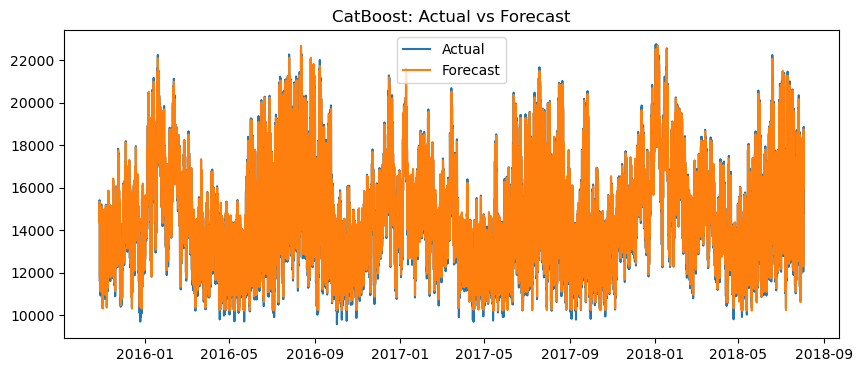

MAE: 414.757 | RMSE: 525.315


In [5]:
# Train and evaluate CatBoost model
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Use the same features and splits as LightGBM
model_cat = CatBoostRegressor(verbose=0, n_estimators=100, random_state=42)
model_cat.fit(X_train_ml, y_train_ml)
pred_cat = model_cat.predict(X_test_ml)

mae_cat = mean_absolute_error(y_test_ml, pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test_ml, pred_cat))

plt.figure(figsize=(10,4))
plt.plot(y_test_ml.index, y_test_ml, label='Actual')
plt.plot(y_test_ml.index, pred_cat, label='Forecast')
plt.title('CatBoost: Actual vs Forecast')
plt.legend()
plt.show()
print(f'MAE: {mae_cat:.3f} | RMSE: {rmse_cat:.3f}')